In [224]:
import copy
import importlib
import os
import re

import anndata
import numpy as np
# import starfysh
import pandas as pd
import scanpy as sc

import scvi
import seaborn as sns
from anndata import AnnData
# import starfysh
from matplotlib import pyplot as plt
from py_pcha import PCHA
from scipy.sparse import issparse
from scipy.spatial.distance import cdist
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sympy.physics.units import current
from tqdm import tqdm
from kneed import KneeLocator

import bar_nick_utils

importlib.reload(bar_nick_utils)

from bar_nick_utils import preprocess_rna, preprocess_protein, plot_archetypes, \
    get_cell_representations_as_archetypes_cvxpy, reorder_rows_to_maximize_diagonal, evaluate_distance_metrics, \
    plot_archetypes_matching, compare_matchings, find_best_pair_by_row_matching, add_spatial_data_to_prot, \
    clean_uns_for_h5ad, get_latest_file
plot_flag = False
# computationally figure out which ones are best
np.random.seed(8)
! which python

/Users/nicholasdjedjos/miniconda3/envs/archetypegen/bin/python


### reading in data

In [225]:
# adata = sc.read("spleen_lymph_cite_seq.h5ad")
adata = scvi.data.spleen_lymph_cite_seq(save_path='data')
# adata for protein, rna take relevant info for each <for each sample>


INFO     File data/sln_111.h5ad already downloaded                                                                 
INFO     File data/sln_208.h5ad already downloaded                                                                 


/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_io/utils.py:213: OldFormatWarning: Element '/obs/batch_indices' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_io/utils.py:213: OldFormatWarning: Element '/obs/n_genes' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_io/utils.py:213: OldFormatWarning: Element '/obs/percent_mito' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_io/utils.py:213: OldFormatWarning: Element '/obs/__categories/leiden_subclusters' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_io/

In [205]:
# from apca.models import *
# n_components=2 # factors have dimensionality of 2
# mu = 1.0 # augmenting objective strength equal to 1
# inference = 'encoded' # encoded approximate inference strategy

# aapca = AAPCA(n_components=n_components, mu=mu, inference=inference)


In [206]:
# # Import numpy
# import numpy as np

# # Generate synthetic data
# # Note: primary and augmenting data must have same number of samples/same first dimension size
# n_samp = 100
# X = np.random.randn(n_samp, 20)   # primary data, 100 samples with dimensionality of 20
# Y = np.random.randn(n_samp, 3)    # concomitant data, 100 samples with dimensionality of 3

# # Fit adversarial AugmentedPCA instance
# aapca.fit(X=X, Y=Y)


In [207]:
# # Import numpy
# import numpy as np

# # Import supervised AugmentedPCA
# from apca.models import SAPCA

# # Generate synthetic data and labels
# n_samp = 100
# X = np.random.randn(n_samp, 20)
# Y = np.random.randint(low=0, high=1, size=(n_samp, 1), dtype=int)

# # Generate test/train splits
# train_pct = 0.7
# idx = np.arange(start=0, stop=101, step=1, dtype=int)
# np.random.shuffle(idx)
# n_train = int(train_pct * len(idx))
# train_idx = idx[:n_train]
# test_idx = idx[n_train:]

# # Split data into test/train sets
# X_train = X[train_idx, :]
# X_test = X[test_idx, :]
# Y_train = Y[train_idx, :]
# Y_test = Y[test_idx, :]

# # Instantiate supervised AugmentedPCA model with local approximate inference strategy
# sapca = SAPCA(n_components=3, mu=5.0, inference='local')

# # Fit supervised AugmentedPCA model
# sapca.fit(X=X_train, Y=Y_train)

# # Generate components for test set
# # Note: both primary and augmenting data are needed to obtain factors
# S_test = sapca.transform(X=X_test, Y=Y_test)


In [226]:
adata_1 = adata[adata.obs['batch'] == f'SLN111-D1']
adata_2 = adata[adata.obs['batch'] == f'SLN111-D2']
fraction = 1
sc.pp.subsample(adata_1, fraction=fraction)
sc.pp.subsample(adata_2, fraction=fraction)
adata_1 = adata_1[adata_1.obs['cell_types'].argsort(), :]  # sort by cell types for easier visualization
adata_2 = adata_2[adata_2.obs['cell_types'].argsort(), :]  # sort by cell types for easier visualization

# initial_adata_rna = adata[adata.obs['batch'] == f'SLN111-D1']
# initial_adata_protein = adata[adata.obs['batch'] == f'SLN208-D1'] 
# get rna from one patient, protein from the other then run the whole archetype analysis
# cell type protein, cell type rna, see which one's 

In [227]:
adata_1

View of AnnData object with n_obs × n_vars = 8736 × 13553
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
    obsm: 'isotypes_htos', 'protein_expression'

In [228]:
cell_type_mapping = {
    "Activated CD4 T": "CD4 T",
    "B1 B": "B cells",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Erythrocytes": "RBC",
    "GD T": "T cells",
    "ICOS-high Tregs": "CD4 T",
    "Ifit3-high B": "B cells",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Ly6-high mono": "Monocytes",
    "Ly6-low mono": "Monocytes",
    "MZ B": "B cells",
    "MZ/Marco-high macrophages": "Macrophages",
    "Mature B": "B cells",
    "Migratory DCs": "cDCs",
    "NK": "NK",
    "NKT": "T cells",
    "Neutrophils": "Neutrophils",
    "Plasma B": "B cells",
    "Red-pulp macrophages": "Macrophages",
    "Transitional B": "B cells",
    "Tregs": "Treg",
    "cDC1s": "cDCs",
    "cDC2s": "cDCs",
    "pDCs": "pDCs",
}
# Map the specific cell types to major cell types and add as a new column in obs
adata.obs['major_cell_types'] = pd.Categorical(adata.obs['cell_types'].map(cell_type_mapping))

adata_1.obs['major_cell_types'] = pd.Categorical(adata_1.obs['cell_types'].map(cell_type_mapping))
adata_2.obs['major_cell_types'] = pd.Categorical(adata_2.obs['cell_types'].map(cell_type_mapping))

assert set(cell_type_mapping.keys()) == set(adata.obs['cell_types'])

# generate major cell types
major_to_minor_dict ={}
# from major to minor dict
for k,v in cell_type_mapping.items():
    if v not in major_to_minor_dict:
        major_to_minor_dict[v] = [k]
    else:
        major_to_minor_dict[v].append(k)

/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_43030/2174369909.py:33: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_1.obs['major_cell_types'] = pd.Categorical(adata_1.obs['cell_types'].map(cell_type_mapping))
/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_43030/2174369909.py:34: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_2.obs['major_cell_types'] = pd.Categorical(adata_2.obs['cell_types'].map(cell_type_mapping))


In [229]:
adata_1

AnnData object with n_obs × n_vars = 8736 × 13553
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types'
    obsm: 'isotypes_htos', 'protein_expression'

In [230]:
print(adata_1.obs['major_cell_types'].value_counts())
print(adata_2.obs['major_cell_types'].value_counts())

major_cell_types
B cells        4459
CD4 T          1892
CD8 T          1432
T cells         219
cDCs            181
Treg            151
Monocytes        99
Macrophages      95
NK               82
Neutrophils      53
pDCs             41
RBC              32
Name: count, dtype: int64
major_cell_types
B cells        3612
CD4 T          1338
CD8 T          1038
T cells         190
cDCs            149
Treg            115
Neutrophils     112
NK              104
Monocytes       101
Macrophages      71
pDCs             30
RBC               8
Name: count, dtype: int64


In [231]:
adata.obs['major_cell_types'].value_counts()

major_cell_types
B cells        15579
CD4 T           6434
CD8 T           4949
T cells          795
cDCs             650
Treg             524
Monocytes        375
NK               341
Neutrophils      313
Macrophages      302
pDCs             130
RBC               82
Name: count, dtype: int64

### preprocessing RNA protein

In [232]:
# Filter cells and genes (different sample)
sc.pp.filter_cells(adata_1, min_genes=100)
sc.pp.filter_genes(adata_1, min_cells=20)
# Identify highly variable genes (for further analysis, could narrow down)
sc.pp.highly_variable_genes(adata_1, n_top_genes=2000, flavor='seurat_v3')


In [233]:

# Scatter plot of variance vs. mean expression
# common approach to inspect the variance of genes. It shows the relationship between mean expression and variance (or dispersion) and highlights the selected highly variable genes.
if plot_flag:
    plt.figure(figsize=(8, 6))
    plt.scatter(adata_1.var['means'], adata_1.var['variances'], alpha=0.3, label='All genes')
    plt.scatter(adata_1.var['means'][adata_1.var['highly_variable']], 
        adata_1.var['variances'][adata_1.var['highly_variable']], 
        color='red', label='Highly variable genes')
    plt.xlabel('Mean expression')
    plt.ylabel('Variance')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.title('Variance vs. Mean Expression of Genes')
    plt.show()


In [216]:
# plt.figure(figsize=(8, 6))
# plt.hist(adata_1.var['variances'], bins=75, alpha=0.7)
# plt.axvline(x=adata_1.var['variances'][adata_1.var['highly_variable']].min(), color='red', linestyle='dashed', label='Cutoff')
# plt.xlabel('Variance')
# plt.ylabel('Frequency')
# plt.yscale('log')
# plt.title('Distribution of Gene Variances')
# plt.legend()
# plt.show()


In [234]:
variances_sorted = np.sort(adata_1.var['variances'])[::-1]

if plot_flag:
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(variances_sorted) + 1), variances_sorted)
    plt.xlabel('Gene rank')
    plt.ylabel('Variance')
    # plt.xscale('log')

    plt.yscale('log')
    plt.title('Elbow plot of Gene Variances')
    plt.axvline(x=1000, color='red', linestyle='dashed', label='n_top_genes=1000')
    plt.legend()
    plt.show()
    plt.figure()
kneedle = KneeLocator(range(1, len(variances_sorted) + 1), np.log(variances_sorted), S=4.0, curve="convex", direction="decreasing")
if plot_flag:
    kneedle.plot_knee()



In [235]:
print(kneedle.knee)

790


In [236]:
sc.pp.highly_variable_genes(adata_1, n_top_genes=kneedle.knee, flavor='seurat_v3')

In [237]:
adata_1 = adata_1[:, adata_1.var['highly_variable']]
print(f"Selected {adata_1.shape[1]} highly variable genes.")
# PCA after selecting highly variable genes
sc.pp.pca(adata_1)
print(
    f"Variance ratio after highly variable gene selection PCA (10 PCs): {adata_1.uns['pca']['variance_ratio'][:10].sum():.4f}")

Selected 790 highly variable genes.
Variance ratio after highly variable gene selection PCA (10 PCs): 0.9594


/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [221]:
adata_1

AnnData object with n_obs × n_vars = 1342 × 105
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'pca'
    obsm: 'isotypes_htos', 'protein_expression', 'X_pca'
    varm: 'PCs'

In [222]:
# ]
adata_1 = adata_1[
    adata_1.obs.sort_values(by=['major_cell_types', 'cell_types']).index
]

adata_2 = adata_2[
    adata_2.obs.sort_values(by=['major_cell_types', 'cell_types']).index
]


In [238]:
# initial adata code (different samples) (takes a little while longer for some reason)
# make sure I do this to adata_2 as well


# ran into this: InvalidIndexError: Reindexing only valid with uniquely valued Index objects

# adata_1 = adata_1[
#     adata_1.obs.sort_values(by=['major_cell_types', 'cell_types']).index
# ]
# so only kept reoccurence of first cell here
# adata_1 = adata_1[
#     ~adata_1.obs.index.duplicated(keep='first') 
# ]
adata_1 = adata_1[
    adata_1.obs.sort_values(by=['major_cell_types', 'cell_types']).index
]

adata_2 = adata_2[
    adata_2.obs.sort_values(by=['major_cell_types', 'cell_types']).index
]

adata_1_rna = adata_1.copy()
sc.pp.pca(adata_1_rna)
print(f'variance explained by first 10 PCs {adata_1_rna.uns["pca"]["variance_ratio"][:10].sum()}')
adata_1_rna = preprocess_rna(adata_1_rna)
sc.pp.pca(adata_1_rna)

adata_1_rna.obsm.pop('protein_expression')
# assert len(set(adata.obs['batch']))!=1

adata_2_prot = AnnData(adata_2.obsm['protein_expression'])
# # add all obs and var to adata_prot
# adata_prot.obs = adata_rna.obs (this is a potential problem as rna and protein obs don't match currently)
adata_2_prot.obs = adata_2.obs 
# remove n_genes and percent_mito from adata_prot

# del adata



variance explained by first 10 PCs 0.9594383239746094
Variance ratio after log transformation PCA (10 PCs): 0.5623
Variance ratio after normalization PCA (10 PCs): 0.5515


/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:797: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value


In [239]:
sc.pp.filter_cells(adata_2_prot, min_genes=90)
sc.pp.filter_genes(adata_2_prot, min_cells=100)

/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [ ]:
if plot_flag:
    sc.pp.pca(adata_2_prot)

    sc.pp.neighbors(adata_2_prot)  # Compute the neighbors needed for UMAP
    sc.tl.umap(adata_2_prot)  # Calculate UMAP coordinates

    sc.pl.umap(adata_2_prot, color='cell_types')

In [ ]:
adata_2_prot.obs = adata_2_prot.obs.drop(columns=['n_genes', 'percent_mito'])
adata_2_prot = preprocess_protein(adata_2_prot)
adata_2_prot.obsm.pop('X_pca')
adata_2_prot.varm.pop('PCs')
original_protein_num = adata_2_prot.X.shape[1]

Variance ratio after PCA (10 PCs): 0.9249

Variance ratio after normalization PCA (10 PCs): 0.9286

Variance ratio after log transformation PCA (10 PCs): 0.6853


In [ ]:
adata_2_prot.X

array([[4.5611334 , 0.        , 1.2457685 , ..., 1.2457685 , 0.4817477 ,
        2.7235775 ],
       [4.046411  , 1.7946101 , 1.6121747 , ..., 1.1008935 , 1.1008935 ,
        3.666894  ],
       [4.525845  , 1.6619946 , 1.2702905 , ..., 1.2702905 , 0.99618256,
        3.6959114 ],
       ...,
       [2.92922   , 2.595189  , 2.2881327 , ..., 1.842755  , 1.5135008 ,
        2.92922   ],
       [2.6289654 , 1.5199643 , 1.3500581 , ..., 1.6651516 , 1.1452533 ,
        3.0100856 ],
       [2.697996  , 1.0607817 , 2.0700185 , ..., 1.0607817 , 0.48829946,
        2.6546774 ]], dtype=float32)

# Synthetic spatial data generation

In [240]:

assert adata_2_prot.obs.index.is_unique

adata_2_prot,horizontal_splits,vertical_splits = add_spatial_data_to_prot(adata_2_prot, major_to_minor_dict)
adata_2_prot.obsm['spatial_location'] = pd.DataFrame([adata_2_prot.obs['X'],adata_2_prot.obs['Y']]).T
if plot_flag:
    sc.pl.scatter(adata_2_prot[adata_2_prot.obs['major_cell_types']=='B cells'], x='X', y='Y', color='cell_types', title='B Cell subtypes locations')
    sc.pl.scatter(adata_2_prot[adata_2_prot.obs['major_cell_types']=='CD4 T'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')
    sc.pl.scatter(adata_2_prot[adata_2_prot.obs['major_cell_types']=='CD8 T'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')


In [241]:
sc.pp.neighbors(adata_2_prot,use_rep='spatial_location')

connectivities = adata_2_prot.obsp['connectivities']
connectivities[connectivities>0]=1
assert np.array_equal(np.array([0., 1.], dtype=np.float32), np.unique(np.array(connectivities.todense())))
if plot_flag:
    sns.heatmap(connectivities.todense()[:10000,:10000])

In [242]:
neighbor_sums = connectivities.dot(adata_2_prot.X) # get the sum of all neighbors
# neighbor_means = neighbor_sums/(0.00001+neighbor_sums.sum(1))[:,np.newaxis] # normalize
neighbor_means = np.asarray(neighbor_sums/connectivities.sum(1))
if plot_flag:
    # showing the first 3 features of 50 cells (should be similar because same major cell type)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.scatterplot(neighbor_means[:50,:3])
    plt.subplot(1,2,2)
    # make sure that the features are independent
    plt.scatter(neighbor_means[:50,0],neighbor_means[:50,1])

In [243]:
# (different samples)
# since we have different samples, we need different final labels after the clustering
# Standardize the data
normalized_data = zscore(neighbor_means, axis=0) # each cell we get the mean of the features of its neighbors
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(normalized_data)

final_labels = np.array(kmeans.labels_)
if 'CN' in adata_2_prot.obs:
    adata_2_prot.obs.drop(columns=['CN'], inplace=True, errors='ignore')
    # adata_1_rna.obs.drop(columns=['CN'], inplace=True, errors='ignore')
adata_2_prot.obs['CN'] = pd.Categorical(final_labels)
# adata_1_rna.obs['CN'] = pd.Categorical(final_labels)
num_clusters = len(adata_2_prot.obs['CN'].unique())

palette = sns.color_palette("tab10", num_clusters)  # "tab10" is a good color map, you can choose others too
adata_2_prot.uns['spatial_clusters_colors'] = palette.as_hex()  # Save as hex color codes


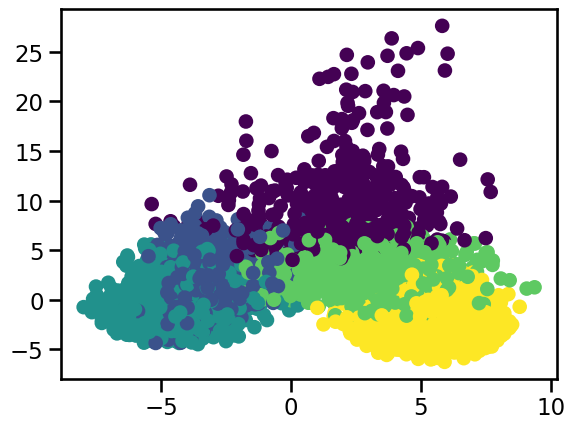

In [244]:
from sklearn.decomposition import PCA
res = PCA(2).fit_transform(normalized_data)
# feature vector mean of each cell's neighbors 
plt.scatter(res[:,0],res[:,1],c=final_labels)


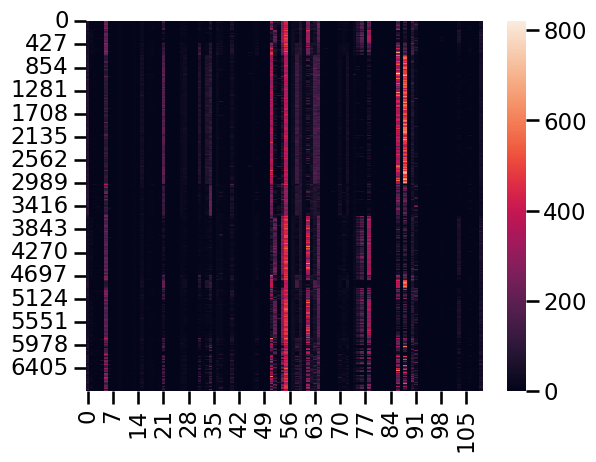

<Axes: >

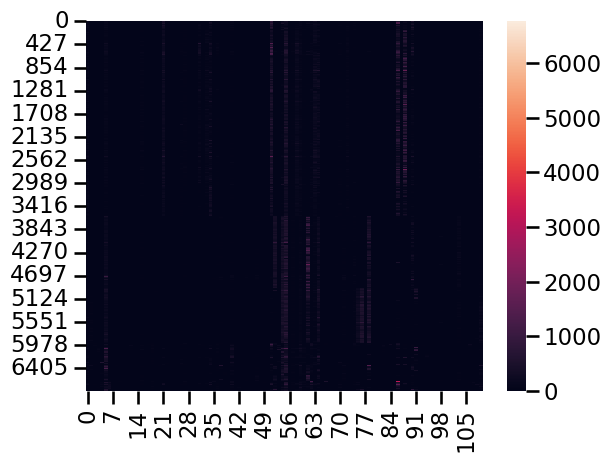

In [245]:
sns.heatmap(neighbor_means) # less noisy because we mean, makes sense as we made sure each cell is of same cell type
plt.show()
sns.heatmap(adata_2_prot.X)

In [246]:
# (different adata technique)
if plot_flag:
    # merge the CN to the protein data
    fig, ax = plt.subplots()
    sc.pl.scatter(
        adata_2_prot,
        x='X', y='Y',
        color='CN', # got this CN from kmeans
        title='Cluster cells by their CN, can see the different CN in different regions, \nthanks to the different B cell types in each region',
        ax=ax,  # Use the ax created above
        show=False  # Prevent scanpy from showing the plot immediately
    )
    for x in horizontal_splits[1:-1]:  # Exclude the edges to avoid border doubling
        ax.axvline(x=x, color='black', linestyle='--')
    for y in vertical_splits[1:-1]:  # Exclude the edges to avoid border doubling
        ax.axhline(y=y, color='black', linestyle='--')
    plt.show()
    
    neighbor_adata = anndata.AnnData(neighbor_means)

    # rna no longer has the CN, using the protein
    neighbor_adata.obs['CN'] = pd.Categorical(adata_2_prot.obs['CN'])

    
    sc.pp.pca(neighbor_adata)
    sc.pp.neighbors(neighbor_adata)
    sc.tl.umap(neighbor_adata)
    sc.pl.umap(neighbor_adata, color='CN', title='UMAP of CN embedding')

    # making sure the CN and the protein are distinct
    adata_prot_cn_concat =anndata.concat([adata_2_prot, neighbor_adata], join='outer', label='modality', keys=['Protein','CN'])
    X = adata_prot_cn_concat.X.toarray() if issparse(adata_prot_cn_concat.X) else adata_prot_cn_concat.X
    X = np.nan_to_num(X)
    adata_prot_cn_concat.X = X
    sc.pp.pca(adata_prot_cn_concat)
    sc.pp.neighbors(adata_prot_cn_concat)
    sc.tl.umap(adata_prot_cn_concat)
    sc.pl.umap(adata_prot_cn_concat,color=['CN','modality'],title=['UMAP of CN embedding','UMAP of CN embedding concatenated'])
    sc.pl.pca(adata_prot_cn_concat, color=['CN','modality'], title=['PCA of CN embedding','PCA of CN embedding concatenated'])


In [247]:
# Assuming `adata_prot` is the original AnnData object
# And `neighbor_means` is the new matrix to be concatenated
# different adata
new_feature_names = [f"CN_{i}" for i in adata_2_prot.var.index]
if adata_2_prot.X.shape[1] == neighbor_means.shape[1]:
    new_X = np.hstack([adata_2_prot.X, neighbor_means])
    additional_var = pd.DataFrame(index=new_feature_names)
    new_vars = pd.concat([adata_2_prot.var, additional_var])
else:
    new_X = adata_2_prot.X
    new_vars = adata_2_prot.var

adata_2_prot = anndata.AnnData(
    X=new_X,
    obs=adata_2_prot.obs.copy(),   # Keep the same observation metadata
    var= new_vars,   # Keep the same variable metadata
    uns=adata_2_prot.uns.copy(),   # Keep the same unstructured data
    obsm=adata_2_prot.obsm.copy(), # Keep the same observation matrices
    # varm=adata_prot.varm.copy(), # Keep the same variable matrices
    layers=adata_2_prot.layers.copy()  # Keep the same layers
)
adata_2_prot.var['feature_type'] = ['protein'] * original_protein_num + ['CN'] * neighbor_means.shape[1]
sc.pp.pca(adata_2_prot) # rerun PCA
print(f"New adata shape (protein features + cell neighborhood vector): {adata_2_prot.shape}")


New adata shape (protein features + cell neighborhood vector): (6823, 220)


# End of CN concatenation to protein features

In [248]:
# different rna, protein data analysis
sc.pp.pca(adata_1_rna)
sc.pp.pca(adata_2_prot)
sc.pp.neighbors(adata_1_rna, key_added='original_neighbors',use_rep='X_pca')
sc.tl.umap(adata_1_rna, neighbors_key='original_neighbors')
adata_1_rna.obsm['X_original_umap'] = adata_1_rna.obsm["X_umap"]
sc.pp.neighbors(adata_2_prot, key_added='original_neighbors',use_rep='X_pca')
sc.tl.umap(adata_2_prot, neighbors_key='original_neighbors')
adata_2_prot.obsm['X_original_umap'] = adata_2_prot.obsm["X_umap"]

if plot_flag:
    sc.pl.pca(adata_1_rna, color=['cell_types', 'major_cell_types'], title=['RNA pca minor cell types', 'RNA pca major cell types'])
    sc.pl.pca(adata_2_prot, color=['cell_types', 'major_cell_types'], title=['Protein pca minor cell types', 'Protein pca major cell types'])
    sc.pl.embedding(adata_1_rna, basis='X_umap', color=[ 'major_cell_types','cell_types'], title=['RNA UMAP major cell types','RNA UMAP major cell types'])
    sc.pl.embedding(adata_2_prot,basis='X_original_umap',color=['major_cell_types','cell_types'],title=['Protein UMAp major cell types','Protein UMAP major cell types'])

In [249]:
# computing a gene module score 
terminal_exhaustion = [
    "CD3G", "FASLG", "ID2", "LAG3", "RGS1",
    "CCL3", "CCL3L1", "KIAA1671", "SH2D2A", "DUSP2",
    "PDCD1", "CD7", "NR4A2", "CD160", "PTPN22",
    "ABI3", "PTGER4", "GZMK", "GZMA", "MBNL1",
    "VMP1", "PLAC8", "RGS3", "EFHD2", "GLRX",
    "CXCR6", "ARL6IP1", "CCL4", "ISG15", "LAX1",
    "CD8A", "SERPINA3", "GZMB", "TOX"
]
precursor_exhaustion = [
    "TCF7", "MS4A4A", "TNFSF8", "CXCL10", "EEF1B2",
    "ID3", "IL7R", "JUN", "LTB", "XCL1",
    "SOCS3", "TRAF1", "EMB", "CRTAM", "EEF1G",
    "CD9", "ITGB1", "GPR183", "ZFP36L1", "SLAMF6",
    "LY6E"
]
cd8_t_cell_activation = [
    "CD69", "CCR7", "CD27", "BTLA", "CD40LG",
    "IL2RA", "CD3E", "CD47", "EOMES", "GNLY",
    "GZMA", "GZMB", "PRF1", "IFNG", "CD8A",
    "CD8B", "CD95L", "LAMP1", "LAG3", "CTLA4",
    "HLA-DRA", "TNFRSF4", "ICOS", "TNFRSF9", "TNFRSF18"
]




In [250]:
adata_1_rna.var_names = adata_1_rna.var_names.str.upper()
adata_2_prot.var_names = adata_2_prot.var_names.str.upper()

In [251]:
sc.tl.score_genes(adata_1_rna, gene_list=terminal_exhaustion, score_name="terminal_exhaustion_score")

       'GZMK', 'MBNL1', 'VMP1', 'RGS3', 'GLRX', 'ARL6IP1', 'LAX1', 'SERPINA3',
       'TOX'],
      dtype='object')


In [255]:
if plot_flag:
    sc.pl.umap(adata_1_rna, color="terminal_exhaustion_score", cmap="viridis")


In [181]:
adata_1_rna

AnnData object with n_obs × n_vars = 8736 × 790
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'pca', 'log1p'
    obsm: 'isotypes_htos', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

### analysis to get to scatter plot

In [135]:
# different adata analysis
adata_2_prot_first_110_vars = adata_2_prot[:, adata_2_prot.var_names[:110]].copy()
adata_2_prot_second_110_vars = adata_2_prot[:, adata_2_prot.var_names[110:]].copy()
sc.pp.pca(adata_2_prot_first_110_vars)
sc.pp.pca(adata_2_prot_second_110_vars)
# plot umap each separately
sc.pp.neighbors(adata_2_prot_first_110_vars)
sc.tl.umap(adata_2_prot_first_110_vars)
sc.pp.neighbors(adata_2_prot_first_110_vars)
sc.tl.umap(adata_2_prot_first_110_vars)
sc.pp.neighbors(adata_2_prot_second_110_vars)
sc.tl.umap(adata_2_prot_second_110_vars)

if plot_flag:
    sc.pl.embedding(adata_2_prot_first_110_vars, basis='X_umap', color=[ 'major_cell_types','cell_types'], title=['Protein UMAP first 110 vars major cell types','Protein UMAP first 110 vars major cell types'])
    sc.pl.embedding(adata_2_prot_second_110_vars, basis='X_umap', color=[ 'major_cell_types','cell_types'], title=['Protein UMAP second 110 vars major cell types','Protein UMAP second 110 vars major cell types'])

In [136]:
# different rna, protein adata analysis
max_possible_pca_dim_rna = min(adata_1_rna.X.shape[1], adata_1_rna.X.shape[0])
max_possible_pca_dim_prot = min(adata_2_prot.X.shape[1], adata_2_prot.X.shape[0])
sc.pp.pca(adata_1_rna, n_comps=max_possible_pca_dim_rna - 1)
sc.pp.pca(adata_2_prot, n_comps=max_possible_pca_dim_prot - 1)
# make PCA explain X% of variance

# going to make pca 25 here just so they have the same number of pca
max_dim = 50
variance_ration_selected = 0.8

cumulative_variance_ratio = np.cumsum(adata_1_rna.uns['pca']['variance_ratio'])
n_comps_thresh = np.argmax(cumulative_variance_ratio >= variance_ration_selected) + 1
n_comps_thresh =min(n_comps_thresh,max_dim)
if n_comps_thresh==1:
    raise ValueError('n_comps_thresh is 1, this is not good, try to lower the variance_ration_selected')
real_ratio = np.cumsum(adata_1_rna.uns['pca']['variance_ratio'])[n_comps_thresh]
# sc.pp.pca(adata_1_rna, n_comps=n_comps_thresh)
sc.pp.pca(adata_1_rna, n_comps=n_comps_thresh)
print(f"\nNumber of components explaining {real_ratio} of rna variance: {n_comps_thresh}\n")
sc.pp.pca(adata_2_prot)
cumulative_variance_ratio = np.cumsum(adata_2_prot.uns['pca']['variance_ratio'])
n_comps_thresh = np.argmax(cumulative_variance_ratio >= variance_ration_selected) + 1
n_comps_thresh =min(n_comps_thresh,max_dim)
real_ratio = np.cumsum(adata_2_prot.uns['pca']['variance_ratio'])[n_comps_thresh]
# sc.pp.pca(adata_2_prot, n_comps=n_comps_thresh)
sc.pp.pca(adata_1_rna, n_comps=n_comps_thresh)
print(f"\nNumber of components explaining {real_ratio} of protein variance: {n_comps_thresh}")
if n_comps_thresh==1:
    raise ValueError('n_comps_thresh is 1, this is not good, try to lower the variance_ration_selected')


Number of components explaining 0.7109060883522034 of rna variance: 50


Number of components explaining 0.8062140345573425 of protein variance: 28


In [137]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Different adata analysis
archetype_list_protein = []
archetype_list_rna = []
converge = 1e-5
min_k = 7  
max_k = 10
step_size = 1

# Store explained variances for plotting the elbow method
evs_protein = []
evs_rna = []

# Protein archetype detection
X_protein = adata_2_prot.obsm['X_pca'].T
total = (max_k - min_k) / step_size
for i, k in tqdm(enumerate(range(min_k, max_k, step_size)), total=total, desc='Protein Archetypes Detection'):
    archetype, _, _, _, ev = PCHA(X_protein, noc=k)
    evs_protein.append(ev)
    archetype_list_protein.append(np.array(archetype).T)
    if i > 0 and evs_protein[i] - evs_protein[i - 1] < converge:
        print('Early stopping for Protein')
        break

# RNA archetype detection
X_rna = adata_1_rna.obsm['X_pca'].T
for j, k in tqdm(enumerate(range(min_k, max_k, step_size)), total=total, desc='RNA Archetypes Detection'):
    if j > i:  
        break
    archetype, _, _, _, ev = PCHA(X_rna, noc=k)
    evs_rna.append(ev)
    archetype_list_rna.append(np.array(archetype).T)
    if j > 0 and evs_rna[j] - evs_rna[j - 1] < converge:
        print('Early stopping for RNA')
        break

# Ensure both lists have the same length
min_len = min(len(archetype_list_protein), len(archetype_list_rna))
archetype_list_protein = archetype_list_protein[:min_len]
archetype_list_rna = archetype_list_rna[:min_len]



Protein Archetypes Detection:   0%|          | 0/3.0 [00:00<?, ?it/s]

Protein Archetypes Detection: 100%|██████████| 3/3.0 [00:15<00:00,  5.15s/it]
RNA Archetypes Detection: 100%|██████████| 3/3.0 [01:00<00:00, 20.16s/it]


In [138]:
# Plot the Elbow Method for both protein and RNA
if plot_flag:
    plt.figure(figsize=(8, 6))
    ks = list(range(min_k, min_k + len(evs_protein)))  # Adjust for early stopping

    plt.plot(ks, evs_protein, marker='o', label='Protein EV')
    plt.plot(ks[:len(evs_rna)], evs_rna, marker='s', label='RNA EV')
    plt.xlabel("Number of Archetypes (k)")
    plt.ylabel("Explained Variance")
    plt.title("Elbow Method for Archetype Selection")
    plt.legend()
    plt.grid()
    plt.show()

In [139]:
# different adata analysis
archetype_list_protein = []

archetype_list_rna = []
converge = 1e-5
min_k = 7  # this is where we set number of archetypes
max_k = 8
step_size = 1

evs = []
X_protein = adata_2_prot.obsm['X_pca'].T
total = (max_k - min_k) / step_size
for i, k in tqdm(enumerate(range(min_k, max_k, step_size)), total=total, desc='Protein Archetypes Detection'):
    archetype, _, _, _, ev = PCHA(X_protein, noc=k)
    evs.append(ev)
    archetype_list_protein.append(np.array(archetype).T)
    if i > 0 and ev - evs[i - 1] < converge:
        print('early stopping')
        break
evs = []
X_rna = adata_1_rna.obsm['X_pca'].T

for j, k in tqdm(enumerate(range(min_k, max_k, step_size)), total=total, desc='RNA Archetypes Detection'):
    if j > i:
        break
    archetype, _, _, _, ev = PCHA(X_rna, noc=k)
    evs.append(ev)
    archetype_list_rna.append(np.array(archetype).T)
    if j > 0 and ev - evs[j - 1] < converge:
        print('early stopping')
        break
min_len = min([len(archetype_list_protein), len(archetype_list_rna)])
archetype_list_protein = archetype_list_protein[:min_len]
archetype_list_rna = archetype_list_rna[:min_len]

Protein Archetypes Detection: 100%|██████████| 1/1.0 [00:05<00:00,  5.99s/it]
RNA Archetypes Detection: 100%|██████████| 1/1.0 [00:31<00:00, 31.79s/it]


In [140]:
# different sample analysis
minor_cell_types_list_prot = sorted(list(set(adata_2_prot.obs['cell_types'])))
major_cell_types_list_prot = sorted(list(set(adata_2_prot.obs['major_cell_types'])))

# have to do this above two lines for rna too
minor_cell_types_list_rna = sorted(list(set(adata_1_rna.obs['cell_types'])))
major_cell_types_list_rna = sorted(list(set(adata_1_rna.obs['major_cell_types'])))

major_cell_types_amount_prot = [adata_2_prot.obs['major_cell_types'].value_counts()[cell_type] for cell_type in
                                major_cell_types_list_prot]
major_cell_types_amount_rna = [adata_1_rna.obs['major_cell_types'].value_counts()[cell_type] for cell_type in
                               major_cell_types_list_rna]
assert set(adata_1_rna.obs['major_cell_types']) == set(adata_2_prot.obs['major_cell_types'])
archetype_proportion_list_rna, archetype_proportion_list_protein = [], []

# i made sure that archetype prot and archetype rna have the same dimensions but still not working

for archetypes_prot, archetypes_rna in tqdm(zip(archetype_list_protein, archetype_list_rna),
                                            total=len(archetype_list_protein),
                                            desc='Archetypes generating archetypes major cell types proportion vector '):
    weights_prot = get_cell_representations_as_archetypes_cvxpy(adata_2_prot.obsm['X_pca'], archetypes_prot)
    weights_rna = get_cell_representations_as_archetypes_cvxpy(adata_1_rna.obsm['X_pca'], archetypes_rna)

    archetypes_dim_prot = archetypes_prot.shape[1] # these dimensions are not 25 anymore, made them 50
    archetype_num_prot = archetypes_prot.shape[0]
    # need to do the above two lines for rna too

    # archetype num prot and rna should be the same?
    archetypes_dim_rna = archetypes_rna.shape[1] # these dimensions are 50
    archetype_num_rna = archetypes_rna.shape[0]  

    # could it be because the minor and major cell types have different lengths for protein and rna?
    prot_arch_prop = pd.DataFrame(np.zeros((archetype_num_prot, len(major_cell_types_list_prot))), columns=major_cell_types_list_prot)
    rna_arch_prop = pd.DataFrame(np.zeros((archetype_num_rna, len(major_cell_types_list_rna))), columns=major_cell_types_list_rna)
    archetype_cell_proportions = np.zeros((archetype_num_prot, len(major_cell_types_list_rna)))
    for curr_archetype in range(archetype_num_prot):
        df_rna = pd.DataFrame([weights_prot[:, curr_archetype], adata_2_prot.obs['major_cell_types'].values],
                              index=['weight', 'major_cell_types']).T
        df_prot = pd.DataFrame([weights_rna[:, curr_archetype], adata_1_rna.obs['major_cell_types'].values],
                               index=['weight', 'major_cell_types']).T
        df_rna = df_rna.groupby('major_cell_types')['weight'].sum()[major_cell_types_list_rna]
        df_prot = df_prot.groupby('major_cell_types')['weight'].sum()[major_cell_types_list_prot]
        # normalize by the amount of major cell types
        rna_arch_prop.loc[curr_archetype, :] = df_rna.values / major_cell_types_amount_rna
        prot_arch_prop.loc[curr_archetype, :] = df_prot.values / major_cell_types_amount_prot

    prot_arch_prop = (prot_arch_prop.T / prot_arch_prop.sum(1)).T
    prot_arch_prop = prot_arch_prop / prot_arch_prop.sum(0)
    rna_arch_prop = (rna_arch_prop.T / rna_arch_prop.sum(1)).T
    rna_arch_prop = rna_arch_prop / rna_arch_prop.sum(0)
    archetype_proportion_list_rna.append(rna_arch_prop.copy())
    archetype_proportion_list_protein.append(prot_arch_prop.copy())

Archetypes generating archetypes major cell types proportion vector : 100%|██████████| 1/1 [02:50<00:00, 170.58s/it]


In [141]:
# lengths of major cell type amount rna and protein are the same
print(major_cell_types_amount_rna)
print(major_cell_types_amount_prot)

[4459, 1892, 1432, 95, 99, 82, 53, 32, 219, 151, 181, 41]
[3586, 1329, 1032, 71, 101, 103, 111, 8, 189, 114, 149, 30]


In [142]:
# plotting the results of the lowest num of archetypes
if plot_flag:
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    # sns.heatmap(reorder_rows_to_maximize_diagonal(archetype_proportion_list_rna[0])[0])
    sns.heatmap((archetype_proportion_list_rna[0]), cbar=False)
    plt.xticks()
    plt.title('RNA Archetypes')
    plt.yticks([])
    plt.ylabel('Archetypes')
    plt.subplot(1, 2, 2)
    plt.title('Protein Archetypes')
    # sns.heatmap(reorder_rows_to_maximize_diagonal(archetype_proportion_list_protein[0])[0])
    sns.heatmap((archetype_proportion_list_protein[0]), cbar=False)
    plt.suptitle('showcase the relationship between archetypes and cell types')
    plt.yticks([])
    plt.suptitle('Non-Aligned Archetypes Profiles')
    plt.ylabel('Archetypes')
    plt.show()

    new_order_1 = reorder_rows_to_maximize_diagonal(archetype_proportion_list_rna[0])[1]
    new_order_2 = reorder_rows_to_maximize_diagonal(archetype_proportion_list_protein[0])[1]
    data1 = archetype_proportion_list_rna[0].iloc[new_order_1, :]
    data2 = archetype_proportion_list_protein[0].iloc[new_order_2, :]
    # this just uses simple diagonal optimization for each one separatly, this is not final matching
    plot_archetypes_matching(data1, data2)


In [143]:
# todo find_best_pair_by_row_matching() find a mathing which has too many archetypes, should check it later
best_num_or_archetypes_index, best_total_cost, best_rna_archetype_order, best_protein_archetype_order = find_best_pair_by_row_matching(
    copy.deepcopy(archetype_proportion_list_rna), copy.deepcopy(archetype_proportion_list_protein), metric='correlation'
)

print("\nBest pair found:")
print(f"Best index: {best_num_or_archetypes_index}")
print(f"Best total matching cost: {best_total_cost}")
print(f"Row indices (RNA): {best_rna_archetype_order}")
print(f"Matched row indices (Protein): {best_protein_archetype_order}")


Pair 0: Total matching cost = 0.23657116903173026

Best pair found:
Best index: 0
Best total matching cost: 0.23657116903173026
Row indices (RNA): [0 1 2 3 4 5 6]
Matched row indices (Protein): [4 6 2 5 3 1 0]


In [144]:
# reorder the archetypes based on the best matching so the archtypes across modalities are aligned
best_archetype_rna_prop = archetype_proportion_list_rna[best_num_or_archetypes_index].iloc[
                          best_rna_archetype_order, :].reset_index(drop=True)
# best_archetype_rna_prop = pd.DataFrame(best_archetype_rna_prop)
best_archetype_prot_prop = archetype_proportion_list_protein[best_num_or_archetypes_index].iloc[
                           best_protein_archetype_order, :].reset_index(drop=True)
# best_archetype_prot_prop = pd.DataFrame(best_archetype_prot_prop)
if plot_flag:
    plot_archetypes_matching(best_archetype_rna_prop, best_archetype_prot_prop,8)

In [145]:
best_archetype_prot_prop.idxmax(axis=0)

B cells        3
CD4 T          0
CD8 T          2
Macrophages    6
Monocytes      6
NK             2
Neutrophils    6
RBC            1
T cells        2
Treg           0
cDCs           6
pDCs           4
dtype: int64

In [146]:
if plot_flag:
    # add lable and laegend
    best_archetype_prot_prop.idxmax(axis=0).plot(kind='bar', color='red', hatch='\\',label='Protein')
    best_archetype_rna_prop.idxmax(axis=0).plot(kind='bar', alpha=0.5, hatch='/',label='RNA')
    plt.title('show overlap of cell types proportions in archetypes')
    # add legend
    plt.legend()
    plt.xlabel('Major Cell Types')
    plt.ylabel('Proportion')
    plt.show()
    compare_matchings(archetype_proportion_list_rna, archetype_proportion_list_protein, metric='cosine',
                      num_trials=100)



In [147]:
best_protein_archetype_order

array([4, 6, 2, 5, 3, 1, 0])

In [148]:
# get all cells archetype vec and see how they match
ordered_best_rna_archetype = archetype_list_rna[best_num_or_archetypes_index][best_protein_archetype_order, :]
ordered_best_protein_archetype = archetype_list_protein[best_num_or_archetypes_index][best_rna_archetype_order, :]
cells_archetype_vec_rna = get_cell_representations_as_archetypes_cvxpy(adata_1_rna.obsm['X_pca'],
                                                                       ordered_best_rna_archetype)
cells_archetype_vec_prot = get_cell_representations_as_archetypes_cvxpy(adata_2_prot.obsm['X_pca'],ordered_best_protein_archetype)

adata_1_rna.obsm['archetype_vec'] = pd.DataFrame(cells_archetype_vec_rna, index=adata_1_rna.obs.index,columns=range(cells_archetype_vec_rna.shape[1]))
adata_2_prot.obsm['archetype_vec'] = pd.DataFrame(cells_archetype_vec_prot, index=adata_2_prot.obs.index,columns=range(cells_archetype_vec_prot.shape[1]))
adata_1_rna.obsm['archetype_vec'].columns = adata_1_rna.obsm['archetype_vec'].columns.astype(str)
adata_2_prot.obsm['archetype_vec'].columns = adata_2_prot.obsm['archetype_vec'].columns.astype(str)

adata_1_rna.obs['archetype_label'] = pd.Categorical(np.argmax(cells_archetype_vec_rna, axis=1))
adata_2_prot.obs['archetype_label'] = pd.Categorical(np.argmax(cells_archetype_vec_prot, axis=1))
adata_1_rna.uns['archetypes'] = ordered_best_rna_archetype
adata_2_prot.uns['archetypes'] = ordered_best_protein_archetype
metrics = ['euclidean', 'cityblock', 'cosine', 'correlation', 'chebyshev']
evaluate_distance_metrics(cells_archetype_vec_rna, cells_archetype_vec_prot, metrics)

Evaluating distance metric: euclidean
Mean Rank: 2681.23 (Random: 3412.00)
MRR: 0.0018 (Random: 0.0014)
Improvement over random (Rank): 21.42%
Improvement over random (MRR): 0.04%

Evaluating distance metric: cityblock
Mean Rank: 2484.35 (Random: 3412.00)
MRR: 0.0019 (Random: 0.0014)
Improvement over random (Rank): 27.20%
Improvement over random (MRR): 0.05%

Evaluating distance metric: cosine
Mean Rank: 2473.06 (Random: 3412.00)
MRR: 0.0020 (Random: 0.0014)
Improvement over random (Rank): 27.53%
Improvement over random (MRR): 0.06%

Evaluating distance metric: correlation
Mean Rank: 2448.88 (Random: 3412.00)
MRR: 0.0023 (Random: 0.0014)
Improvement over random (Rank): 28.24%
Improvement over random (MRR): 0.09%

Evaluating distance metric: chebyshev
Mean Rank: 2765.48 (Random: 3412.00)
MRR: 0.0017 (Random: 0.0014)
Improvement over random (Rank): 18.95%
Improvement over random (MRR): 0.03%



{'euclidean': {'mean_rank': 2681.234940641946,
  'expected_mean_rank': 3412.0,
  'mrr': 0.0017714184915988828,
  'expected_mrr': 0.0013784762540634036,
  'rank_improvement': 0.21423777758957896,
  'mrr_improvement': 0.0003934846467774004,
  'ranks': array([ 161,  178,  174, ..., 1473, 1418, 1621])},
 'cityblock': {'mean_rank': 2484.3467682837463,
  'expected_mean_rank': 3412.0,
  'mrr': 0.0018912493896903033,
  'expected_mrr': 0.0013784762540634036,
  'rank_improvement': 0.2719593174190131,
  'mrr_improvement': 0.0005134809569329455,
  'ranks': array([ 165,  245,  128, ..., 3179, 1541, 1861])},
 'cosine': {'mean_rank': 2473.0605305584054,
  'expected_mean_rank': 3412.0,
  'mrr': 0.0020270646614763545,
  'expected_mrr': 0.0013784762540634036,
  'rank_improvement': 0.27526809423676185,
  'mrr_improvement': 0.0006494837052780779,
  'ranks': array([ 170,  215,  367, ..., 1841, 1615, 1950])},
 'correlation': {'mean_rank': 2448.8843617177195,
  'expected_mean_rank': 3412.0,
  'mrr': 0.002279

In [149]:
# add the best matching archetype to the metadata
adata_1_rna.obs['archetype_label'] = pd.Categorical(np.argmax(cells_archetype_vec_rna, axis=1))
adata_2_prot.obs['archetype_label'] = pd.Categorical(np.argmax(cells_archetype_vec_prot, axis=1))

In [150]:
if plot_flag:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.ylabel('Archetypes')
    plt.xlabel('PCA dimensiton of archetypes')
    plt.title('RNA Archetypes')
    sns.heatmap(ordered_best_rna_archetype)
    plt.subplot(1, 2, 2)
    plt.ylabel('Archetypes')
    plt.xlabel('PCA dimensiton of archetypes')
    plt.title('Protein Archetypes')
    sns.heatmap(ordered_best_protein_archetype)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('RNA Archetypes')
    plt.ylabel('Archetypes')
    _, row_order = reorder_rows_to_maximize_diagonal(best_archetype_rna_prop)
    sns.heatmap(pd.DataFrame(best_archetype_rna_prop).iloc[row_order], cbar=False)  
    plt.yticks([])
    plt.ylabel('Archetypes')
    plt.subplot(1, 2, 2)
    
    plt.ylabel('Archetypes')
    plt.title('Protein Archetypes')
    sns.heatmap(pd.DataFrame(best_archetype_prot_prop).iloc[row_order], cbar=False)  
    plt.ylabel('Archetypes')
    # plt.suptitle('The more similar the better, means that the archetypes are aligned in explaining different cell types')
    plt.suptitle('Aligned Archetypes Profiles')
    plt.yticks([])

    plt.show()
    



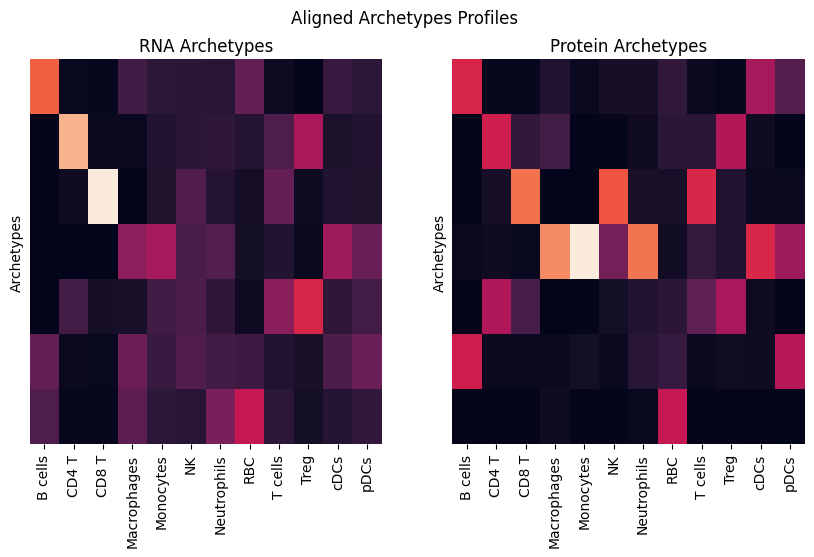

In [151]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('RNA Archetypes')
plt.ylabel('Archetypes')
_, row_order = reorder_rows_to_maximize_diagonal(best_archetype_rna_prop)
sns.heatmap(pd.DataFrame(best_archetype_rna_prop).iloc[row_order], cbar=False)  
plt.yticks([])
plt.ylabel('Archetypes')
plt.subplot(1, 2, 2)

plt.ylabel('Archetypes')
plt.title('Protein Archetypes')
sns.heatmap(pd.DataFrame(best_archetype_prot_prop).iloc[row_order], cbar=False)  
plt.ylabel('Archetypes')
# plt.suptitle('The more similar the better, means that the archetypes are aligned in explaining different cell types')
plt.suptitle('Aligned Archetypes Profiles')
plt.yticks([])

plt.show()
    

In [152]:

archetype_distances = cdist(cells_archetype_vec_rna,
                            cells_archetype_vec_prot, metric='correlation')
if plot_flag:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(np.log1p(archetype_distances[:1000, :1000]))
    plt.title(
        'if diagonal bias this mean that the \nmathing is somewhat correct (remember that cells are sorted by tyeps for better visualization ')
    plt.subplot(1, 2, 2)
    # plt.plot(archetype_distances.argmin(axis=0))
    plt.title('If this looks like line, matching \nARE THE SAME AND NOT ACROSS MODALITIES')
    min_values_highlight = archetype_distances.copy()
    min_values_highlight[archetype_distances.argmin(axis=0), range(len(archetype_distances.argmin(axis=0)))] = 100
    sns.heatmap(min_values_highlight[:5000, :5000])
    # sns.heatmap(np.log1p(archetype_distances[:100,:100]))
    plt.show()


In [153]:
if plot_flag:
    ax = sns.histplot(adata_1_rna.obs, x='archetype_label', hue='major_cell_types', multiple='fill', stat='proportion')
    plt.xticks(rotation=45)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title('Proportion of Archetypes in Major Cell Types  in RNA')
    plt.show()

    ax = sns.histplot(adata_2_prot.obs, x='archetype_label', hue='major_cell_types', multiple='fill', stat='proportion')
    plt.xticks(rotation=45)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title('Proportion of Archetypes in Major Cell Types in Protein')


In [154]:
def plot_scatter(mtx1, mtx2, n_samples):
    pca = PCA(n_components=2)
    embeddings_combined = np.vstack((mtx1, mtx2))
    tsne_results = pca.fit_transform(embeddings_combined)
    # tsne_results = pca.fit_transform(embeddings_combined)

    labels = ['Dataset 1'] * n_samples + ['Dataset 2'] * n_samples
    df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    df['Dataset'] = labels

    sns.scatterplot(x='TSNE1', y='TSNE2', hue='Dataset', data=df)
    plt.title('t-SNE of Aligned Embeddings')
    plt.show()


### weights

In [155]:
if plot_flag:
    # plot both heatmaps as subplots, and add titel the more similar the better:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('RNA Archetypes')
    plt.ylabel('Archetypes')
    _,row_order = reorder_rows_to_maximize_diagonal(best_archetype_rna_prop)
    sns.heatmap(pd.DataFrame(best_archetype_rna_prop).loc[row_order,:])
    # sns.heatmap(pd.DataFrame(best_archetype_rna_prop))
    plt.subplot(1, 2, 2)
    plt.ylabel('Archetypes')
    # sns.heatmap(best_archetype_prot_prop)
    sns.heatmap(pd.DataFrame(best_archetype_prot_prop).loc[row_order,:])
    # sns.heatmap(pd.DataFrame(best_archetype_prot_prop).iloc[row_order,:])
    plt.title('Protein Archetypes')
    plt.suptitle('The more similar the better, means that the archtypes are aligned in explaining different cell types')
    plt.show()
    # errors = np.abs(ordered_arch_prot - ordered_arch_rna)
    # random_error =np.abs(ordered_arch_prot - np.random.permutation(ordered_arch_rna))
    # plt.plot(errors.values.flatten())
    # plt.plot(random_error.values.flatten())
    # plt.legend(['Error', 'Random Error'])
    # plt.show()

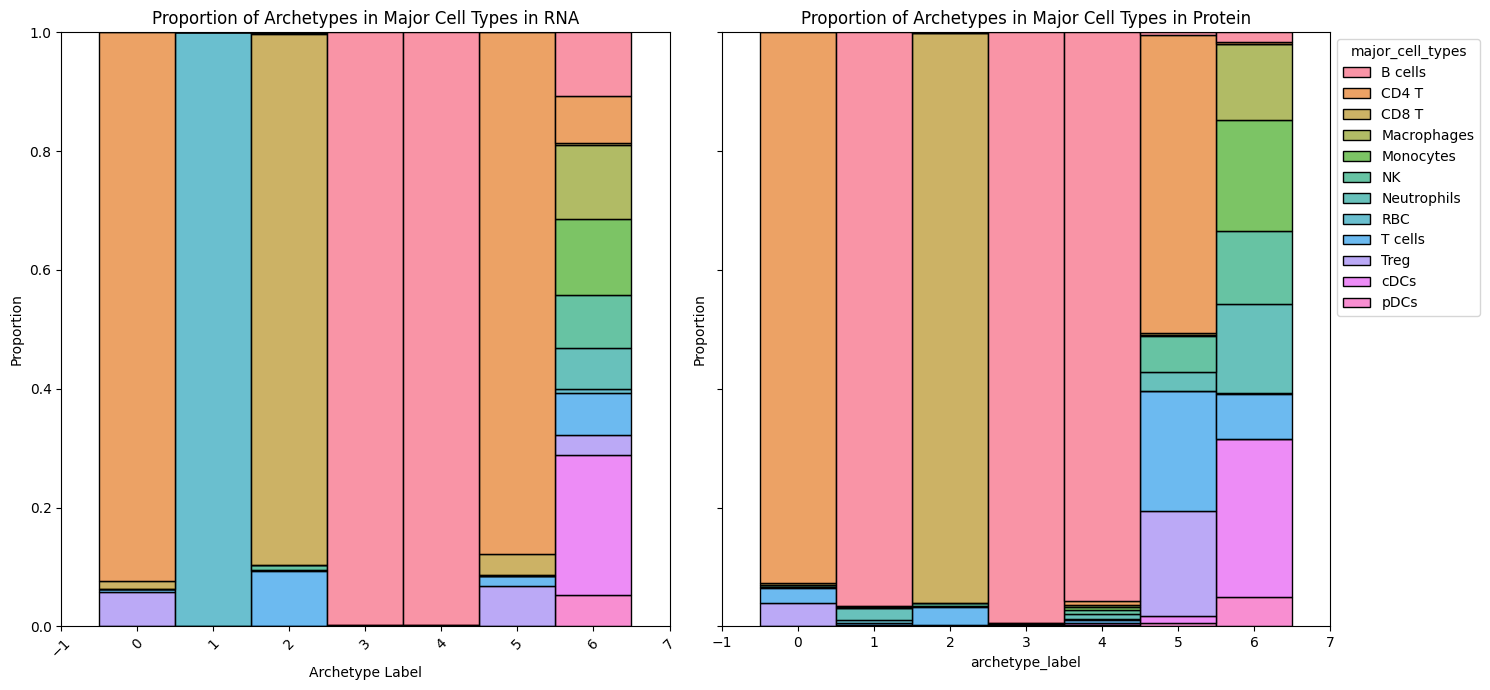

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot for RNA
ax = sns.histplot(adata_1_rna.obs, x='archetype_label', hue='major_cell_types', multiple='fill', stat='proportion', ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())  # Set the ticks first
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Proportion of Archetypes in Major Cell Types in RNA')
axes[0].set_xlabel('Archetype Label')
axes[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axes[0].get_legend().remove()  # Remove the legend from the left subplot

# Plot for Protein
ax = sns.histplot(adata_2_prot.obs, x='archetype_label', hue='major_cell_types', multiple='fill', stat='proportion', ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())  # Set the ticks first
axes[1].set_yticklabels([])
axes[1].set_title('Proportion of Archetypes in Major Cell Types in Protein')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()
# TODO this plot does not add up for some reason, it seems that the archetypes are not aligned correctly

In [157]:
if plot_flag:
    data_points_rna = adata_1_rna.obsm['X_pca']
    data_points_prot = adata_2_prot.obsm['X_pca']
    data_point_archetype_indices_rna = list(np.argmax(cells_archetype_vec_rna, axis=1))
    data_point_archetype_indices_prot = list(np.argmax(cells_archetype_vec_prot, axis=1))

    # use ground truth cell types
    show_ground_truth =True
    if show_ground_truth:
        major_or_minor = 'cell_types'
        major_or_minor = 'major_cell_types'
        samples_cell_types_rna = list(adata_1_rna.obs[major_or_minor])
        samples_cell_types_prot = list(adata_2_prot.obs[major_or_minor])
    else: #
        # Get the archetype indices for each data point
        major_cell_types_list = minor_cell_types_list_rna
        current_cell_types_list = major_cell_types_list
        # Map the archetype indices to cell type names
        samples_cell_types_rna = [current_cell_types_list[i] for i in data_point_archetype_indices_rna]
        samples_cell_types_prot = [current_cell_types_list[i] for i in data_point_archetype_indices_prot]

    

    # Optionally limit the number of samples
    num_samples = 50000  # or any number you prefer
    data_points_rna_plot = data_points_rna[:num_samples]
    data_points_prot_plot = data_points_prot[:num_samples]
    samples_cell_types_rna_plot = samples_cell_types_rna[:num_samples]
    samples_cell_types_prot_plot = samples_cell_types_prot[:num_samples]
    data_point_archetype_indices_rna_plot = data_point_archetype_indices_rna[:num_samples]
    data_point_archetype_indices_prot_plot = data_point_archetype_indices_prot[:num_samples]

    # Create a consistent color mapping
    all_cell_types = set(samples_cell_types_rna_plot + samples_cell_types_prot_plot)
    all_cell_types.discard('archetype')
    all_cell_types = [ct for ct in all_cell_types if ct is not np.nan]
    all_cell_types = sorted(all_cell_types)
    palette = sns.color_palette("tab20", len(all_cell_types))
    cell_type_colors = {cell_type: color for cell_type, color in zip(all_cell_types, palette)}
    cell_type_colors["archetype"] = "black"

    # Call the updated function with the color mapping
    plot_archetypes(
        data_points_rna_plot,
        ordered_best_rna_archetype,
        samples_cell_types_rna_plot,
        data_point_archetype_indices_rna_plot,
        modality='RNA',
        cell_type_colors=cell_type_colors
    )
    plot_archetypes(
        data_points_prot_plot,
        ordered_best_protein_archetype,
        samples_cell_types_prot_plot,
        data_point_archetype_indices_prot_plot,
        modality='Protein',
        cell_type_colors=cell_type_colors
    )


In [158]:
adata_archetype_rna = AnnData(adata_1_rna.obsm['archetype_vec'])
adata_archetype_prot = AnnData(adata_2_prot.obsm['archetype_vec'])
adata_archetype_rna.obs = adata_1_rna.obs
adata_archetype_prot.obs = adata_2_prot.obs
adata_archetype_rna.index = adata_1_rna.obs.index
adata_archetype_prot.index = adata_2_prot.obs.index
if plot_flag:
    sc.pp.pca(adata_archetype_rna)
    sc.pp.pca(adata_archetype_prot)
    sc.pl.pca(adata_archetype_rna, color=['major_cell_types', 'archetype_label', 'cell_types'])
    sc.pl.pca(adata_archetype_prot, color=['major_cell_types', 'archetype_label', 'cell_types'])
    sc.pp.neighbors(adata_archetype_rna)
    sc.pp.neighbors(adata_archetype_prot)
    sc.tl.umap(adata_archetype_rna)
    sc.tl.umap(adata_archetype_prot)
    sc.pl.umap(adata_archetype_rna, color=['major_cell_types', 'archetype_label', 'cell_types'])
    sc.pl.umap(adata_archetype_prot, color=['major_cell_types', 'archetype_label', 'cell_types'])

In [159]:
if plot_flag:
    # making sure that the archetypes make sense in original data context
    sc.pp.neighbors(adata_1_rna)
    sc.pp.neighbors(adata_2_prot)
    sc.tl.umap(adata_1_rna)
    sc.tl.umap(adata_2_prot)
    sc.pl.umap(adata_1_rna, color='archetype_label', title='RNA Archetypes')
    sc.pl.umap(adata_2_prot, color='archetype_label', title='Protein Archetypes')

In [160]:
adata_1_rna

AnnData object with n_obs × n_vars = 8736 × 790
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'archetype_label'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'pca', 'log1p', 'original_neighbors', 'umap', 'archetypes'
    obsm: 'isotypes_htos', 'X_pca', 'X_umap', 'X_original_umap', 'archetype_vec'
    varm: 

In [161]:
t_cell_terminal_exhaustion = [
    "CD3G", "FASLG", "ID2", "LAG3", "RGS1", "CCL3", "CCL3L1", "KIAA1671",
    "SH2D2A", "DUSP2", "PDCD1", "CD7", "NR4A2", "CD160", "PTPN22", "ABI3",
    "PTGER4", "GZMK", "GZMA", "MBNL1", "VMP1", "PLAC8", "RGS3", "EFHD2",
    "GLRX", "CXCR6", "ARL6IP1", "CCL4", "ISG15", "LAX1", "CD8A", "SERPINA3",
    "GZMB", "TOX"
]

t_cell_precursor_exhaustion = [
    "TCF7", "MS4A4A", "TNFSF8", "CXCL10", "EEF1B2", "ID3", "IL7R", "JUN",
    "LTB", "XCL1", "SOCS3", "TRAF1", "EMB", "CRTAM", "EEF1G", "CD9",
    "ITGB1", "GPR183", "ZFP36L1", "SLAMF6", "LY6E"
]

t_cell_t_reg = [
    "NT5E", "CD3D", "CD3G", "CD3E", "CD4",
    "CD5", "ENTPD1", "CTLA4", "IZUMO1R", "TNFRSF18",
    "IL2RA", "ITGAE", "LAG3", "TGFB1", "LRRC32",
    "TNFRSF4", "SELL", "FOXP3", "STAT5A", "STAT5B",
    "LGALS1", "IL10", "IL12A", "EBI3", "TGFB1"
]



In [162]:
# save all adata objects with time stamp
clean_uns_for_h5ad(adata_2_prot)
clean_uns_for_h5ad(adata_1_rna)
time_stamp = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")
adata_1_rna.write(f'data/adata_rna_{time_stamp}.h5ad')
adata_2_prot.write(f'data/adata_prot_{time_stamp}.h5ad')
adata_archetype_rna.write(f'data/adata_archetype_rna_{time_stamp}.h5ad')
adata_archetype_prot.write(f'data/adata_archetype_prot_{time_stamp}.h5ad')
# load the latest of each sort by time as if I dont have the time stamp, read all files in the right name prefix and sort by time in a folder
folder = 'data/'
file_prefixes = ['adata_rna_', 'adata_prot_', 'adata_archetype_rna_', 'adata_archetype_prot_']

# Load the latest files (example)
latest_files = {prefix: get_latest_file(folder, prefix) for prefix in file_prefixes}
adata_rna = sc.read(latest_files['adata_rna_'])
adata_prot = sc.read(latest_files['adata_prot_'])
adata_archetype_rna = sc.read(latest_files['adata_archetype_rna_'])
adata_archetype_prot = sc.read(latest_files['adata_archetype_prot_'])

